## Group 7 Notebook 1: Classifier Implementation

This notebook presents the implementation of a classifier model (specifically a Random Forest classifier, as will be explained below) to predict the crystal structures of the 5000+ perovskites in the given dataset ("Crystal_structure.csv").

The model presented here is the Random Forest classifier, as that is the model that has given the best accuracy score out of the Support Vector Machine and K-Nearest Neigbours models. This will be shown explicitly in Notebook 2.

In [1]:
import numpy as np
import pandas as pd

# IMPORT SCIKIT-LEARN MODULES
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# IMPORT CLASSIFIER MODULES
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# IMPORT MODULES FOR PLOTTING
import seaborn as sns
from matplotlib import pyplot as plt

## Preprocessing

After the .csv file containing the dataset is imported as a dataframe, a few preprocessing steps are performed.

1. All rows with missing values tagged as '-' are removed.
2. All rows that have Goldschmidt factor values outside of the range (0.82, 1.1) or μ values outside of the range (0.414, 0.732) are removed. This is because below outside of those ranges, the perovskite structure is not stable, and thus those values are invalid for our classification.
3. All rows where the v(A) and v(B) values do not add up to 6 are invalid and are removed.
4. Columns v(B) and r(AVI)(Å) are dropped because they are highly correlated with columns v(A) and r(AXII)(Å) respectively.

This leaves us with a grand total of 675 rows and 12 feature columns.

In [2]:
class Classifier:
    """Container for analysing the dataset using different classification models."""
    def __init__(self, estimator, fname: str, **kwargs):
        
        # initialise the classifier
        self.estimator = estimator(**kwargs)
        
        # import csv as a dataframe and tag rows containing '-' as missing values
        self.df = pd.read_csv(fname, na_values=['-'])
        
    def clean_up(self):
        """Remove rows with mising data and invalid data."""
        
        # drop missing value and reset index
        self.df.dropna(inplace=True)
        self.df.reset_index(drop=True, inplace=True)
        
        # drop rows that don't satisfy the second requirement
        for index in self.df.index:
            total_valency = int(self.df['v(A)'][index]) + int(self.df['v(B)'][index])
            if total_valency != 6:
                self.df.drop(index, inplace=True)
            if not (0.82 < float(self.df['tG'][index]) < 1.1) or not (0.414 < float(self.df['μ'][index]) < 0.732):
                self.df.drop(index, inplace=True)
                
        self.df.reset_index(drop=True, inplace=True)
        
    def run_classifier(self):
        """Sets the feature and target columns, performs the training/testing split, and fits the classifier."""
        
        # set feature columns as every column besides the 'Compound', 'A', 'B', and 'Lowest distortion' columns
        self.X = self.df.drop(['Compound', 'A', 'B', 'Lowest distortion'], axis=1)
        
        # drop highly correlated features
        self.X = self.X.drop(['v(B)', 'r(AVI)(Å)'], axis=1)
        
        # feature scaling for X using min-max scaling
        self.X = MinMaxScaler().fit_transform(self.X)
        
        # set target column as the 'Lowest distortion' column
        self.y = self.df['Lowest distortion']
        
        # training and testing split with random ratio
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=1)
        
        # fit training set to estimator
        self.estimator.fit(self.X_train, self.y_train)
        
        # generate prediction set
        self.y_pred = self.estimator.predict(self.X_test)
        
    def correlation(self):
        """Plots a heatmap of the correlation matrix."""
        correlation_matrix = self.df.corr()
        correlation_heatmap = sns.heatmap(correlation_matrix, cmap="RdPu", annot=True, fmt=".2f", cbar=False)
        return correlation_heatmap
        
    def score(self):
        """Returns the accuracy score of the latest prediction."""
        return accuracy_score(self.y_test, self.y_pred)
    
    def grid(self, **kwargs):
        """Runs the GridSearch cross-validation algorithm to find the best parameters and CV score for the classifier."""
        self.param_grid = {
            'bootstrap': [True],
            'max_depth': [10, 40, 70, 100],
            'max_features': [1,2],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [200, 500, 1000, 2000]
        }
        self.grid_search = GridSearchCV(
            estimator = self.estimator, 
            param_grid = self.param_grid, 
            cv = 3,
            n_jobs = -1, 
            verbose = 2, 
            scoring = 'accuracy'
        )
        self.grid_search.fit(self.X_train, self.y_train)
        return self.grid_search.best_params_, self.grid_search.score(self.X_test, self.y_test)

## Classifier Implementation

The class is implemented to the dataset and the score is printed.

In [3]:
foo = Classifier(RandomForestClassifier, 'Crystal_structure.csv')
foo.clean_up()
foo.run_classifier()

print(foo.score())

0.725925925925926


## Correlated Features Justification

As was explained at the top of this notebook, two correlated features, v(A) and r(AVI)(Å), are removed from the dataset. This was justified by means of a correlation matrix which is plotted below. The correlation score between v(A) and v(B) was -1.00, so v(B) was removed. The correlation score between r(AVI) and l(B-O) is slightly high at 0.85, so it has been removed as well.

AxesSubplot(0.125,0.125;0.775x0.755)


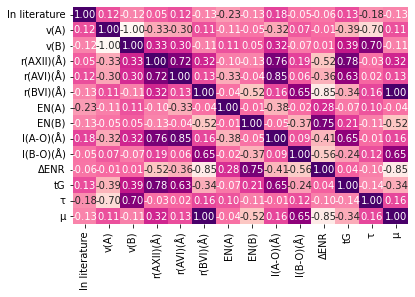

In [6]:
print(foo.correlation())

After running the GridSearch CV algorithm, the best parameters determined for the Random Forest Classifier are as follows:

best_params = {
    'bootstrap': True, 
    'max_depth': 10, 
    'max_features': 1, 
    'min_samples_leaf': 1, 
    'min_samples_split': 2, 
    'n_estimators': 200}
    
This should be the expected output when running the code cell below, which might take up to 3 minutes to present an output.

In [5]:
best_params, new_score = foo.grid()

print(f'The best parameters for the classifier are {best_params}\n which yields an accuracy score of {new_score}')

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  2.7min finished


The best parameters for the classifier are {'bootstrap': True, 'max_depth': 100, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2000}
 which yields an accuracy score of 0.725925925925926
